<a href="https://colab.research.google.com/github/haritha-venkat/mpwebsite/blob/main/mpfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:

train_folder = '/content/drive/MyDrive/dataset/Data/train'
test_folder = '/content/drive/MyDrive/dataset/Data/test'
validate_folder = '/content/drive/MyDrive/dataset/Data/valid'

normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'


In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

print("Libraries Imported")

# Read data from the folders
IMAGE_SIZE = (350, 350)

print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 8

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


Libraries Imported
Reading training images from: /content/drive/MyDrive/dataset/Data/train
Reading validation images from: /content/drive/MyDrive/dataset/Data/valid
Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=8, verbose=2, factor=0.5, min_lr=0.00001)
early_stops = EarlyStopping(monitor='loss', min_delta=0, patience=9, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath='best_model.keras', verbose=2, save_best_only=True, save_weights_only=False)


In [7]:
# Uninstall current TensorFlow version
!pip uninstall tensorflow -y

# Install TensorFlow 2.15
!pip install tensorflow==2.15


Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling

In [18]:
OUTPUT_SIZE = 4

pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print("Pretrained model used:")
pretrained_model.summary()

print("Final model created:")
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Pretrained model used:
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 350, 350, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 174, 174, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 174, 174, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 174, 174, 32)         0         

In [21]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder

def load_images_as_numpy_arrays(folder_path, image_size=(350, 350)):
    X = []
    y = []
    class_names = os.listdir(folder_path)  # Assuming each class has a subfolder

    for label in class_names:
        label_folder = os.path.join(folder_path, label)
        for image_name in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_name)
            image = load_img(image_path, target_size=image_size)
            image = img_to_array(image) / 255.0  # Normalize
            X.append(image)
            y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

# Load the data
train_folder = train_folder  # Update with actual path
X, y = load_images_as_numpy_arrays(train_folder)
y = LabelEncoder().fit_transform(y)  # Encode labels numerically


In [24]:
# Step 1: Load images and labels
X, y = load_images_as_numpy_arrays(train_folder)
y = LabelEncoder().fit_transform(y)  # Encode labels as integers

# Step 2: One-hot encode the labels
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=4)  # Adjust `num_classes` to match the number of output classes

# Step 3: Cross-validation setup
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Cross-validation parameters
k_folds = 5
epochs = 50
batch_size = 8
image_size = (350, 350, 3)
output_size = 4

# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
accuracies, val_accuracies = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y.argmax(axis=1))):  # y.argmax(axis=1) to get labels for stratification
    print(f'\nStarting fold {fold + 1}/{k_folds}...')

    # Split data for this fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Define the model for each fold
    model = Sequential([
        Xception(weights='imagenet', include_top=False, input_shape=image_size),
        GlobalAveragePooling2D(),
        Dense(output_size, activation='softmax')
    ])
    model.layers[0].trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks for each fold
    callbacks = [
        ReduceLROnPlateau(monitor='loss', patience=8, verbose=2, factor=0.5, min_lr=0.00001),
        EarlyStopping(monitor='loss', patience=9, verbose=2),
        ModelCheckpoint(f'best_model_fold_{fold + 1}.keras', save_best_only=True)
    ]

    # Data generators for training and validation
    train_datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator()

    # Train the model for this fold
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=batch_size),
        validation_data=val_datagen.flow(X_val, y_val, batch_size=batch_size),
        epochs=epochs,
        callbacks=callbacks,
        steps_per_epoch=len(X_train) // batch_size,
        validation_steps=len(X_val) // batch_size
    )

    # Record metrics for this fold
    accuracies.append(history.history['accuracy'][-1])
    val_accuracies.append(history.history['val_accuracy'][-1])

    print(f"Fold {fold + 1} - Training accuracy: {accuracies[-1]}, Validation accuracy: {val_accuracies[-1]}")

# Print average metrics across folds
print(f'\nAverage Training Accuracy across folds: {np.mean(accuracies)}')
print(f'Average Validation Accuracy across folds: {np.mean(val_accuracies)}')



Starting fold 1/5...
Epoch 1/50
61/61 [==============================] - 13s 151ms/step - loss: 1.1594 - accuracy: 0.4834 - val_loss: 0.9347 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 8s 124ms/step - loss: 0.8747 - accuracy: 0.6203 - val_loss: 0.8214 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 7s 113ms/step - loss: 0.7677 - accuracy: 0.6867 - val_loss: 0.7315 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 7s 118ms/step - loss: 0.6974 - accuracy: 0.7199 - val_loss: 0.6916 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 7s 115ms/step - loss: 0.6256 - accuracy: 0.7905 - val_loss: 0.6604 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 6s 102ms/step - loss: 0.5621 - accuracy: 0.7925 - val_loss: 0.7134 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 7/50
61/61 [=============================

In [27]:
# After training is complete
model.save('finalmodel.h5')


In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    callbacks=[learning_rate_reduction, early_stops, checkpointer],
    validation_data=validation_generator,
    validation_steps=20
)

print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.2621 - accuracy: 0.3650
Epoch 1: val_loss improved from inf to 1.10955, saving model to best_model.keras
25/25 [==============================] - 14s 465ms/step - loss: 1.2621 - accuracy: 0.3650 - val_loss: 1.1096 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.0242 - accuracy: 0.5584
Epoch 2: val_loss improved from 1.10955 to 1.01022, saving model to best_model.keras
25/25 [==============================] - 6s 254ms/step - loss: 1.0242 - accuracy: 0.5584 - val_loss: 1.0102 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.9549 - accuracy: 0.6050
Epoch 3: val_loss improved from 1.01022 to 0.96376, saving model to best_model.keras
25/25 [==============================] - 8s 320ms/step - loss: 0.9549 - accuracy: 0.6050 - val_loss: 0.9638 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 4/50
25/25 [================

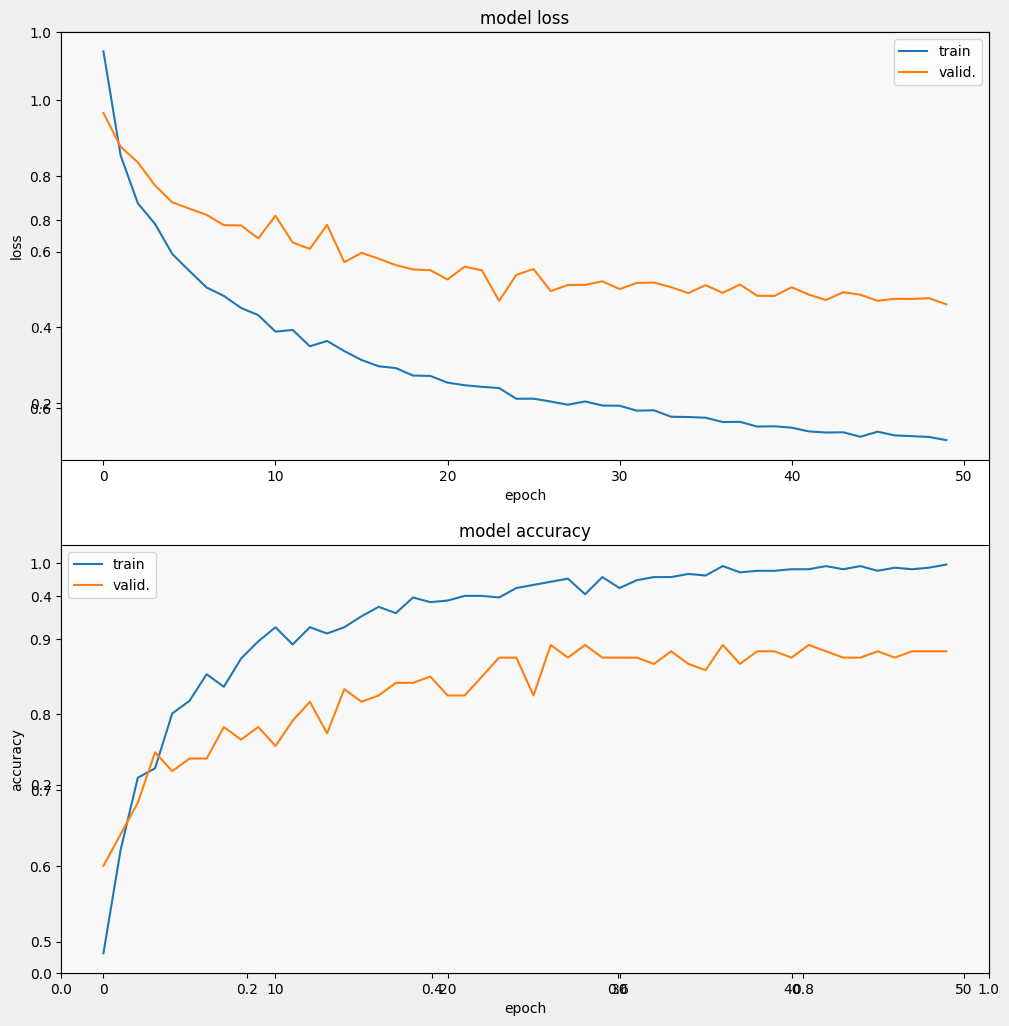

In [30]:
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)


In [28]:
model.save('/content/drive/MyDrive/dataset/finalmodel.h5')


1/1 [==============================] - 2s 2s/step
The image belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


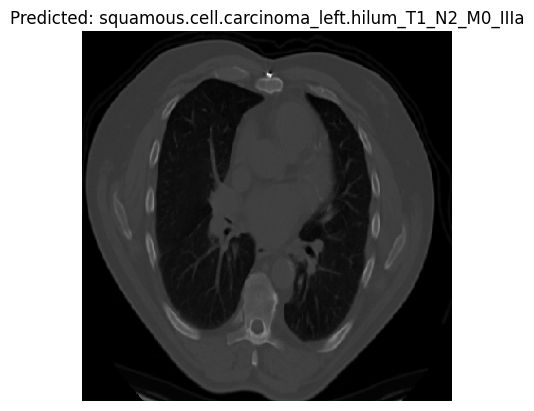

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/sq.png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


In [34]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('finalmodel.h5')  # Load your model

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(350, 350))  # Resize image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image (if needed)

    return img_array

# Test the model with a new image
img_path = '/content/000131.png'  # Replace with your image path
processed_image = preprocess_image(img_path)

# Make the prediction
predictions = model.predict(processed_image)

# Get the predicted class (for multi-class classification)
predicted_class = np.argmax(predictions, axis=-1)

# Or for binary classification
# predicted_class = (predictions > 0.5).astype("int32")

# Class labels (update these according to your model)
class_labels = ['squamous', 'large', 'adeno', 'normal']  # Replace with your actual class labels

# Display the result
print(f"Predicted class: {class_labels[predicted_class[0]]}")


1/1 [==============================] - 1s 951ms/step
Predicted class: squamous


1/1 [==============================] - 1s 1s/step
The image belongs to class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa


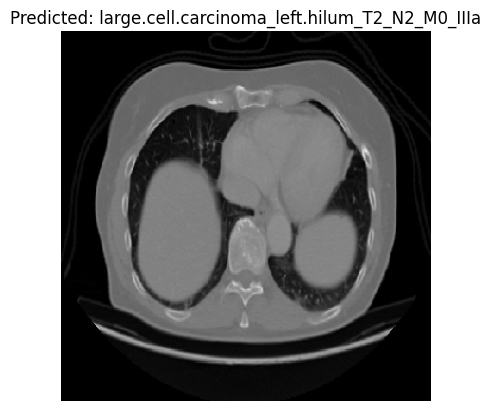

In [41]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define the target image size (should match the model input size)
IMAGE_SIZE = (350, 350)  # Example size; replace with the actual input size of your model

# Load the trained model
model = load_model('finalmodel.h5')  # Replace with the path to your saved model

# Load the training generator (to get the class indices)
# Assuming you have the train_generator already created during training
# For example: train_generator = image.ImageDataGenerator().flow_from_directory('train_dir', ...)

# Use the class indices from the training generator
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Map from index to label

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the image like the training images (if needed)
    return img_array

# Load an image from your drive
img_path = '/content/000150.png'  # Replace with the actual image path
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])  # Get the index of the highest probability

# Map the predicted class index to the class label
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image with the predicted class as title
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 [==============================] - 1s 876ms/step
The image belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


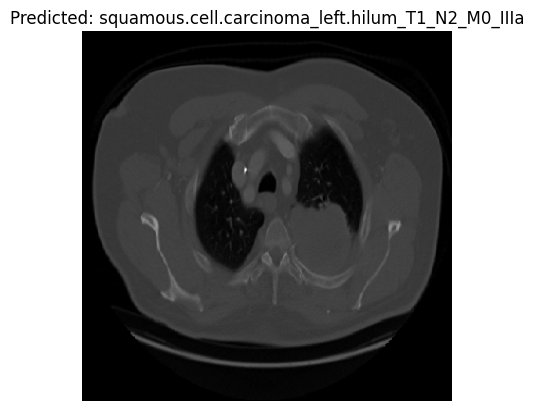

In [38]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define the target image size (should match the model input size)
IMAGE_SIZE = (350, 350)  # Example size; replace with the actual input size of your model

# Load the trained model
model = load_model('finalmodel.h5')  # Replace with the path to your saved model

# Load the training generator (to get the class indices)
# Assuming you have the train_generator already created during training
# For example: train_generator = image.ImageDataGenerator().flow_from_directory('train_dir', ...)

# Use the class indices from the training generator
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Map from index to label

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the image like the training images (if needed)
    return img_array

# Load an image from your drive
img_path = '/content/000173 (2).png'  # Replace with the actual image path
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])  # Get the index of the highest probability

# Map the predicted class index to the class label
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image with the predicted class as title
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 29ms/step
The image belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


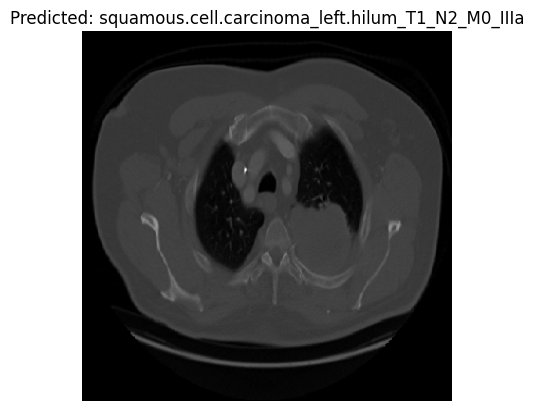

In [39]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/000173 (2).png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 [==============================] - 1s 796ms/step
The image belongs to class: normal


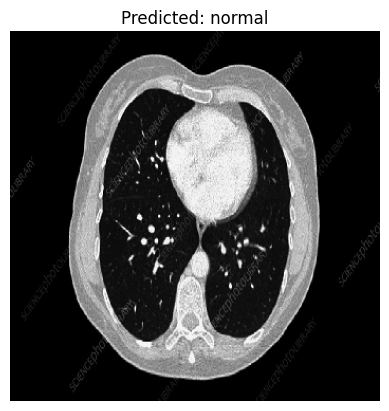

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/n8.jpg'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
